In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import locale
import mibian
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

In [2]:
# URL de la página a hacer scraping
url = 'https://www.meff.es/esp/Derivados-Financieros/Ficha/FIEM_MiniIbex_35'

# Realizar la petición HTTP GET a la página
response = requests.get(url)

In [30]:
def obtener_dataframe(response, tipo_tabla):
    """
    Realiza el web scraping y devuelve un dataframe con los datos obtenidos,
    dependiendo si el tipo de tabla es 'opciones' o 'futuros'.
    
    Args:
    - response: La respuesta HTTP obtenida.
    - tipo_tabla: Tipo de la tabla a buscar ('opciones' o 'futuros').
    
    Returns:
    - Un dataframe con los datos de la tabla.
    """
    # Determinar el ID de la tabla y si se necesita manejar el atributo data-tipo
    if tipo_tabla == 'opciones':
        id_tabla = 'tblOpciones'
        es_opcion = True
    elif tipo_tabla == 'futuros':
        id_tabla = 'Contenido_Contenido_tblFuturos'
        es_opcion = False
    else:
        print("Tipo de tabla no soportado.")
        return pd.DataFrame()
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('table', id=id_tabla)
        all_rows_data = []
        
        if table:
            rows = table.find_all('tr', class_='text-right')
            
            for row in rows:
                cells = row.find_all('td')
                row_data = [cell.text.strip() for cell in cells]
                
                if es_opcion:
                    data_tipo = row.get('data-tipo', 'No especificado')
                    row_data.insert(0, data_tipo)
                    
                all_rows_data.append(row_data)
                
            return pd.DataFrame(all_rows_data)
        else:
            print('No se encontró la tabla con el id especificado.')
            return pd.DataFrame()
    else:
        print('Error al realizar la petición HTTP:', response.status_code)
        return pd.DataFrame()

In [48]:
def tratar_dataframe(df, tipo_tabla):
    """
    Transforma el dataframe según si es de opciones o de futuros.
    
    Args:
    - df: Dataframe a transformar.
    - tipo_tabla: Tipo de la tabla ('opciones' o 'futuros').
    
    Returns:
    - Un dataframe transformado.
    """
    if tipo_tabla == 'opciones':
        # Especificar los nombres de columna para opciones
        df.columns = ['Class', 'Strike', 'Buy_ord', 'Buy_vol', 'Buy_price', 'Sell_price', 'Sell_vol', 'Sell_ord', 'Ult', 'Vol', 'Aper', 'Max.', 'Min.','Ant']
        df['Tipo'] = df['Class'].str[:3]
        df['Fecha'] = pd.to_datetime(df['Class'].str[3:], format='%Y%m%d').dt.strftime('%d-%m-%Y')
        df = df.drop(['Class'], axis=1)
        
        # Transformaciones adicionales para opciones
        df['Strike'] = df['Strike'].str.replace('.', '').str.replace(',', '.').astype(float)
        df['Ant'] = pd.to_numeric(df['Ant'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        df['Buy_price'] = pd.to_numeric(df['Buy_price'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        df['Sell_price'] = pd.to_numeric(df['Sell_price'].str.replace('.', '').str.replace(',', '.'), errors='coerce')

        df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d-%m-%Y')
        
        # Seleccionando solo las columnas deseadas para opciones
        df = df.loc[:, ['Tipo', 'Fecha', 'Strike', 'Buy_price', 'Sell_price', 'Ant']]
        
    elif tipo_tabla == 'futuros':
        # Especificar los nombres de columna para futuros
        df.columns = ['Vencimiento', 'Tipo', 'Buy_ord', 'Buy_vol', 'Buy_price', 'Sell_price', 'Sell_vol', 'Sell_ord', 'Ult', 'Vol', 'Aper', 'Max.', 'Min.','Ant']
        
        # Configurar locale a español
        locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8' if locale.windows_locale is None else 'Spanish')
        df['Vencimiento'] = pd.to_datetime(df['Vencimiento'], format='%d %b %Y')
        df['Ant'] = pd.to_numeric(df['Ant'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        
        # Seleccionando solo las columnas deseadas para futuros
        df = df.loc[:, ['Vencimiento', 'Ant']]
        
    else:
        print("Tipo de tabla no soportado.")
        return pd.DataFrame()
    
    return df

In [ ]:
def calcular_precio_opcion(row, tipo):
    """
    Calcula el precio de la opción, ya sea 'call' o 'put'.
    
    Args:
    - row: La fila del DataFrame.
    - tipo: Tipo de opción ('call' o 'put').
    
    Returns:
    - Precio calculado de la opción.
    """
    if tipo == 'call':
        buy_col = 'Buy_price_call'
        sell_col = 'Sell_price_call'
    elif tipo == 'put':
        buy_col = 'Buy_price_put'
        sell_col = 'Sell_price_put'
    else:
        raise ValueError("Tipo de opción no soportado. Use 'call' o 'put'.")
    
    if pd.notna(row[buy_col]) and pd.notna(row[sell_col]):
        return (row[buy_col] + row[sell_col]) / 2
    elif pd.notna(row[buy_col]):
        return row[buy_col]
    elif pd.notna(row[sell_col]):
        return row[sell_col]
    else:
        return None

In [88]:
def datos_opciones(tipo_tabla, response):
    
    df = obtener_dataframe(response, tipo_tabla)
    df = tratar_dataframe(df, tipo_tabla)
    
    df_c = df[df['Tipo'] == 'OCE'].copy()
    df_p = df[df['Tipo'] == 'OPE'].copy()

    df_c.rename(columns={'Buy_price': 'Buy_price_call', 'Sell_price': 'Sell_price_call', 'Ant': 'Ant_call'}, inplace=True)
    df_p.rename(columns={'Buy_price': 'Buy_price_put', 'Sell_price': 'Sell_price_put', 'Ant': 'Ant_put'}, inplace=True)
    
    # Unir los dataframes por 'Strike' y 'Fecha'
    df_final = pd.merge(df_c, df_p, on=['Fecha', 'Strike'], how='outer')

    # Ordenar por 'Fecha' y 'Strike'
    df_final.sort_values(by=['Fecha', 'Strike'], ascending=[True, True], inplace=True)
        
    # Establecer 'Fecha' como índice
    df_final.set_index('Fecha', inplace=True)

    # Calcular la columna 'T' en el DataFrame combined_df
    df_final['T'] = (df_final.index - pd.Timestamp(datetime.now().date())).days / 365.25

    df_final = df_final[['Strike', 'Buy_price_call', 'Sell_price_call', 'Buy_price_put', 'Sell_price_put', 'T']]

    # Aplicar la función para crear las columnas 'Precio_call' y 'Precio_put'
    df_final['Precio_call'] = df_final.apply(calcular_precio_opcion, tipo='call', axis=1)
    df_final['Precio_put'] = df_final.apply(calcular_precio_opcion, tipo='put', axis=1)

    return df_final

In [89]:
def datos_futuros(tipo_tabla, response):
    df = obtener_dataframe(response, 'futuros')
    df = tratar_dataframe(df, 'futuros')

    return df


In [90]:
# Opciones
df_opciones = datos_opciones('opciones', response)

In [93]:
# Opciones
df_futuros = datos_futuros('futuros', response)

**Cálculo volatilidades implícitas**

In [94]:
# Función para calcular el precio de una opción call europea usando Black-Scholes
def black_scholes_call(S, K, T, r, sigma):
    if T <= 0:  # No se puede calcular precio de una opción con tiempo hasta vencimiento negativo o cero
        return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    if T <= 0:  # No se puede calcular precio de una opción con tiempo hasta vencimiento negativo o cero
        return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Función para extraer la volatilidad implícita
def implied_volatility(option_price, S, K, T, r, option_type):
    """Calcula la volatilidad implícita de una opción dada su precio de mercado.
    option_price : Precio de mercado de la opción
    S : Precio del activo subyacente
    K : Precio de ejercicio
    T : Tiempo hasta el vencimiento
    r : Tasa de interés libre de riesgo
    option_type : Tipo de opción ('call' o 'put')
    """
    if option_price <= 0 or T <= 0:
        return 0
    # Función objetivo para encontrar la volatilidad implícita
    def objective(sigma):
        if option_type == 'call':
            return black_scholes_call(S, K, T, r, sigma) - option_price
        else:
            return black_scholes_put(S, K, T, r, sigma) - option_price
    # Resolver usando Brent's method
    try:
        result = brentq(objective, 1e-6, 4)
        return result
    except ValueError:
        return np.nan  



In [95]:
price_sub = df_futuros.loc[0, 'Ant']
rfr = 0

In [96]:
# Calcular la volatilidad implícita para cada opción en combined_df
df_opciones['Vol_call'] = df_opciones.apply(lambda row: implied_volatility(row['Precio_call'], price_sub, row['Strike'], row['T'], rfr, 'call'), axis=1)
df_opciones['Vol_put'] = df_opciones.apply(lambda row: implied_volatility(row['Precio_put'], price_sub, row['Strike'], row['T'], rfr, 'put'), axis=1)

In [99]:
volatilidades = df_opciones.loc[:, ['Strike', 'Vol_call', 'Vol_put']]
volatilidades

,Strike,Vol_call,Vol_put
Fecha,,,
2024-04-26,9000.0,1.937855,1.272949
2024-04-26,9100.0,1.855312,1.212644
2024-04-26,9200.0,1.773120,1.152708
2024-04-26,9300.0,1.691226,1.093110
2024-04-26,9400.0,1.609573,1.033818
...,...,...,...
2025-06-20,13300.0,0.135517,0.071983
2025-06-20,13400.0,0.135251,NaN
2025-06-20,13500.0,0.135067,NaN


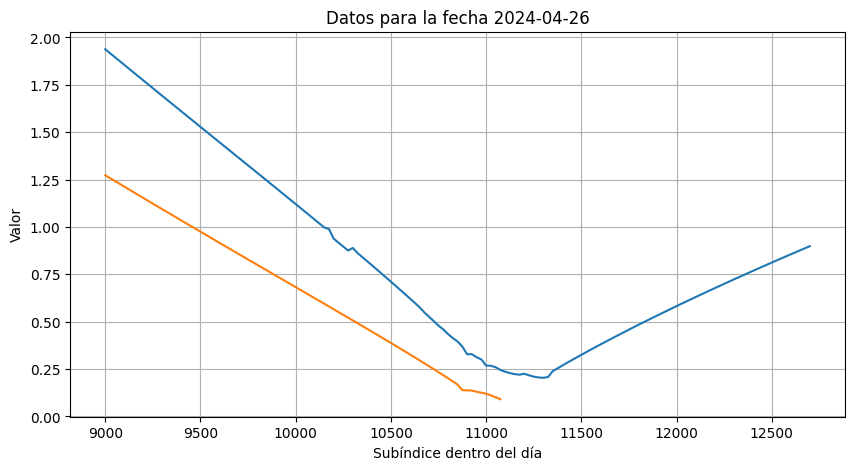

In [100]:
# Paso 1: Definir la fecha que quieres graficar
fecha_deseada = '2024-04-26'  # Cambia esta fecha según tus necesidades

# Paso 2: Filtrar los datos para la fecha seleccionada
datos_filtrados_call = volatilidades.loc[fecha_deseada]
datos_filtrados_put = volatilidades.loc[fecha_deseada]

# Paso 3: Graficar los datos
plt.figure(figsize=(10, 5))  # Configura el tamaño del gráfico como desees
plt.plot(datos_filtrados_call['Strike'], datos_filtrados_call['Vol_call'], linestyle='-')
plt.plot(datos_filtrados_put['Strike'], datos_filtrados_put['Vol_put'], linestyle='-')
# Asegúrate de reemplazar 'tu_columna_de_datos' con el nombre de la columna real que deseas graficar

plt.title(f'Datos para la fecha {fecha_deseada}')
plt.xlabel('Subíndice dentro del día')  # Ajusta según la estructura de tu DataFrame
plt.ylabel('Valor')  # Ajusta este label según los datos que estás graficando
plt.grid(True)
plt.show()